### 1-D Richards equation solver code
- formulation based on a backward Euler implementation of the mixed theta-head formulation of the 1-D Richards equation, with a modified Picard iteration finite differencing solution scheme, with a modified Picard iteration finite differencing solution scheme.

- The soil water retention parameterization used is that of van Genuchten 
 [1980], and this code requires the corresponding MATLAB function        
 vanGenuchten.m.  
 
 - coordinate axis:  positive  upward
         z[-1] = zmax  (top)
         z[0] = 0  (bottom)

In [1]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import time

In [2]:
%matplotlib inline

In [3]:
def vanGenuchten(h,phi) :
    alpha   = phi['alpha']
    theta_S = phi['theta_S']
    theta_R = phi['theta_R']
    n       = phi['n']
    m       = phi['m']
    Ksat    = phi['ksat'] 
    # Compute the volumetric moisture content
    theta = (theta_S - theta_R)/(1 + (alpha*abs(h))**n)**m + theta_R
    # Compute the effective saturation
    Se = ((theta - theta_R)/(theta_S - theta_R))
    # Compute the hydraulic conductivity
    K = Ksat*Se**(1./2)*(1 - (1 - Se**(1./m))**m)**2
    # Compute the specific moisture storage
    C =  -alpha*n*np.sign(h)*(1./n - 1)*(alpha*abs(h))**(n - 1)*(theta_R - 
         theta_S)*((alpha*abs(h))**n + 1)**(1/n - 2)
    try:
        for i in range(len(h)):
            if h[i] > 0:
                K[i] = Ksat[i]
                C[i] = 0.
                theta[i] = theta_S[i]
    except TypeError:
        if h > 0:
            K = Ksat[i]
            C = 0.
            theta = theta_S[i]
    return [C,K,theta]

In [4]:
# Define van Genuchten parameters
# Seal layer
sealAlpha   = 0.0078  
sealTheta_S = 0.450  
sealTheta_R = 0.0394  
sealLambdA  = 0.263  
sealn       = sealLambdA + 1
sealm       = sealLambdA/sealn
sealKsat    = 0.19/3600. 
# veg areas / below the seal layer
vegAlpha   = 0.0096  
vegTheta_S = 0.472  
vegTheta_R = 0.0378  
vegLambdA  = 0.318 
vegn       = vegLambdA + 1
vegm       = vegLambdA/vegn
vegKsat    = 3.38/3600. 

In [5]:
# set up grid 
dz = .1; # [cm]
zmin = 0.; # [cm]
zmax = 10.; # [cm]
z = np.arange(zmin, zmax+dz, dz)
nz = z.shape[0]
zs = 4.  # cm  
si = np.where(z == z[-1] - zs)[0][0]  

In [6]:
alpha = np.ones(nz)*vegAlpha
theta_S = np.ones(nz)*vegTheta_S
theta_R = np.ones(nz)*vegTheta_R
lambdA = np.ones(nz)*vegLambdA
ksat = np.ones(nz)*vegKsat

alpha[si:] = sealAlpha
theta_S[si:] = sealTheta_S
theta_R[si:] = sealTheta_R
lambdA[si:] = sealLambdA
ksat[si:] = sealKsat

n = lambdA + 1
m = lambdA/n
phi = {'alpha': alpha,
       'theta_R': theta_R,
       'theta_S': theta_S,
       'theta_S': theta_S,
       'lambdA': lambdA,
       'n': n, 
       'm': m, 
       'ksat': ksat,
      }

In [7]:
# Define matrices that we'll need in solutiona
DeltaPlus  = np.diag(-np.ones(nz)) + np.diag(np.ones(nz-1), 1)
DeltaPlus[0,:] = 0
DeltaPlus[nz-1,:] = 0

DeltaMinus = np.diag(np.ones(nz)) + np.diag(-np.ones(nz-1),-1);
DeltaMinus[0,:] = 0
DeltaMinus[nz-1,:] = 0

MPlus = np.diag(np.ones(nz))+np.diag(np.ones(nz-1),1)
MPlus[0,0] = 2
MPlus[0,1:nz-1] = 0
MPlus[nz-1,nz-1] = 2
MPlus[nz-1,:nz-1] = 0  # not needed

MMinus = np.diag(np.ones(nz)) + np.diag(np.ones(nz-1),-1)
MMinus[0,0] = 2
MMinus[0,1:nz-1] = 0  # not needed
MMinus[nz-1,nz-1] = 2
MMinus[nz-1,:nz-1] = 0 


In [84]:
# Define time variables
stop_tol = 1e-9 # Stopping tolerance [cm]
dt  = .01 # [s]
tmin = 0. # [s]
tmax = 10 # [s]

t = np.arange(tmin, tmax + dt, dt)
nt = t.shape[0]

In [85]:
# ICs
case = 'rain'

if case == 'rain':
    setflux = 1
    prate = 1./3600  # cm/hr
    # hinit = -100*np.ones(nz)
    hinit = - np.arange(nz)*dz 
    fmtstr = 'dt={0}, tol={1}, p={2:.0e}'.format(dt, stop_tol, prate)

if case == 'fixed_H':
    setflux = 0
    hinit = -1000*np.ones(nz)
    htop = -30.
    hinit[-1] = htop
    # hinit =   np.arange(nz)*5 - 500; htop = hinit[-1]
    fmtstr = 'dt={0}, tol={1}, htop={2}'.format(dt, stop_tol, htop)


In [86]:
 def timestep(hnp1m, thetan, setflux = 1, flux = - prate, htop = 0., 
              stop_tol = stop_tol):
    """
    """
    stop_flag = 0
    niter = 0
    while(stop_flag == 0):
        # Layer S:
        [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi)
        Cdiag = np.diag(cnp1m) 
        kbarplus = (1/2.)*MPlus.dot(knp1m)
        Kbarplus = np.diag(kbarplus)
        kbarminus = (1/2.)*MMinus.dot(knp1m)
        Kbarminus = np.diag(kbarminus)
        A = (1./dt)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - 
                                          Kbarminus.dot(DeltaMinus)) 
        R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - \
                               Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
             (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan) 
        deltam = np.linalg.pinv(A).dot(R_MPFD)
        niter = niter + 1
#         if niter > 100.:
#             stop_tol = stop_tol*10.
#             niter = 0
        if (max(abs(deltam[1:(nz-1)]))<stop_tol):
            stop_flag = 1
            hnp1mp1 = hnp1m + deltam 
            hnp1mp1[0] = hnp1mp1[1]  # free drainage BC
            if setflux == 1:
                [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
                kt = (knp1m[-2] + knp1m[-2])/2.
                hnp1mp1[-1] =  hnp1mp1[-2] - dz - flux*dz/kt
            else:
                hnp1mp1[-1] = htop
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
            knp1mp1 = knp1m
            cnp1mp1 = cnp1m            
            hnp1m = hnp1mp1
        else:        
            hnp1mp1 = hnp1m + deltam
            hnp1m = hnp1mp1
            hnp1m[0] = hnp1m[1] 
            if setflux == 1:
                [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi);
                kt = (knp1m[-2] + knp1m[-2])/2.
                hnp1m[-1] = hnp1m[-2] - dz - flux*dz/kt
            else:
                hnp1m[-1] = htop
    errornp1 =  np.sum(A.dot(deltam))*dt*dz
    
    return hnp1mp1,cnp1mp1,knp1mp1, thetanp1m, errornp1, niter, stop_tol

In [87]:
 def pot_infl(hnp1m, thetan, htop = 0):
    """
    """
    stop_flag = 0
    niter = 0
    while(stop_flag == 0):
        [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi)
        Cdiag = np.diag(cnp1m) 
        kbarplus = (1/2.)*MPlus.dot(knp1m)
        Kbarplus = np.diag(kbarplus)
        kbarminus = (1/2.)*MMinus.dot(knp1m)
        Kbarminus = np.diag(kbarminus)
        A = (1./dt)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - 
                                          Kbarminus.dot(DeltaMinus)) 
        #  Compute the residual of MPFD (RHS)
        R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - \
                               Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
             (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan); 
        # Compute deltam for iteration level m+1
        deltam = np.linalg.pinv(A).dot(R_MPFD)
        # Increment iteration counter and display number of iterations
        niter = niter + 1;
        if (max(abs(deltam[1:(nz-1)]))<stop_tol):
            stop_flag = 1
            hnp1mp1 = hnp1m + deltam 
            hnp1mp1[0] = hnp1mp1[1]  # free drainage BC
            hnp1mp1[-1] = htop
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
            knp1mp1 = knp1m
            cnp1mp1 = cnp1m            
            hnp1m = hnp1mp1
            PI = (knp1mp1[-2] + knp1mp1[-2])/2.*((hnp1mp1[-1] - hnp1mp1[-2])/dz + 1.)
        else:
            hnp1mp1 = hnp1m + deltam
            hnp1m = hnp1mp1
            hnp1m[0] = hnp1m[1] 
            hnp1m[-1] = htop
    return PI

In [88]:
if setflux == 1:
    [Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) 
    kt = (Kinit[-2] + Kinit[-2])/2.
    PI = pot_infl(hinit, thetainit, htop = 0)
    hinit[-1] = hinit[-2] - dz + PI*dz/kt

# use output from previous run:
# hinit = hnp1mp1

# Define a storage container to store the pressure heads and soil moistures
[Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) 
H = np.zeros([nz,nt])
K = np.zeros([nz,nt])
C = np.zeros([nz,nt])
H[:,0] = hinit
K[:,0] = Kinit
C[:,0] = Cinit

THETA = np.zeros([nz,nt])
THETA[:,0] = thetainit
ktop = np.zeros([ nt])
kbot = np.zeros([ nt])
error = np.zeros([nt])


In [89]:
depth = 0.
# setflux = 1
start_time = time.time()
iterations = np.zeros([nt]);  # Define array for iteration counter
new_tol = np.zeros([nt]);
depths = np.zeros([nt]);
for i in range(1, nt):   # Initialize the Picard iteration solver
 
    hnp1m =  H[:,i-1]  
    thetan = THETA[:,i-1]
    
    if depth <= 0:
        PI = pot_infl(hnp1m, thetan, htop = 0.)
        if np.mod(i,100) == 0:
            print t[i], 'PI = {0:.2f}cm/hr; rain = {1:.2f}cm/hr; t = {2:.2f}'.format(
                PI*3600,prate*3600, t[i])
        if  PI < prate:
            flux = - PI
            print 'ponding at time t=', t[i]
        else:
            flux = - prate
            
        hnp1mp1,cnp1mp1,knp1mp1, thetanp1mp1,errornp1,niter, tol = \
           timestep(hnp1m,thetan,  setflux = 1, flux = flux)
        depth += prate*dt + flux*dt
        
    else:
        hnp1mp1,cnp1mp1,knp1mp1, thetanp1mp1, errornp1,niter, tol = \
                        timestep(hnp1m,thetan,  setflux = 0, htop = depth)
        infl =  (knp1mp1[-1] + knp1mp1[-2])/2.*((hnp1mp1[-1] - hnp1mp1[-2])/dz + 1.)*dt 

        kt = (knp1mp1[-2] + knp1mp1[-2])/2.       
        # PI =  pot_infl(hnp1m, thetan, htop = depth)
        # print PI/(kt*((hnp1mp1[-1] - hnp1mp1[-2])/dz + 1.))
        depth +=  prate*dt - kt*((hnp1mp1[-1] - hnp1mp1[-2])/dz + 1.)*dt 
    
    if np.mod(i,100) == 0:
         print t[i], 'depth = {0:.2f}cm; rain = {1:.2f} cm/hr'.format(depth,prate*3600)
    THETA[:,i] = thetanp1mp1
    H[:,i] = hnp1mp1
    K[:, i]= knp1mp1
    C[:,i] = cnp1mp1
    kbot[i] =  (K[0, i] + K[1, i])/2.  
    ktop[i] =  (K[-1, i] + K[-2, i])/2.  
    error[i] = errornp1
    new_tol[i] = tol
    depths[i] = depth
#    error[i] = dz*np.sum(C[:,i]*deltam[:]) +  kbot[i]*(deltam[1] - deltam[0])*dt/dz \
#           ktop[i]*(deltam[-1] - deltam[-2])*dt/dz
    iterations[i] = niter
    

fluxin =    ktop*((H[-1] - H[-2])/dz + 1.)*dt   # top flux (cm)
fluxout = - kbot*((H[1] - H[0])/dz + 1.)*dt # bottom flux (cm)
newmass =  (THETA[:, 1:] - THETA[:, :-1]).sum(0)   #  change in mass 

print("--- %s seconds ---" % (time.time() - start_time))

1.0 PI = 3.54cm/hr; rain = 1.00cm/hr; t = 1.00
1.0 depth = 0.00cm; rain = 1.00 cm/hr
2.0 PI = 2.94cm/hr; rain = 1.00cm/hr; t = 2.00
2.0 depth = 0.00cm; rain = 1.00 cm/hr
3.0 PI = 2.40cm/hr; rain = 1.00cm/hr; t = 3.00
3.0 depth = 0.00cm; rain = 1.00 cm/hr
4.0 PI = 1.87cm/hr; rain = 1.00cm/hr; t = 4.00
4.0 depth = 0.00cm; rain = 1.00 cm/hr
5.0 PI = 1.32cm/hr; rain = 1.00cm/hr; t = 5.00
5.0 depth = 0.00cm; rain = 1.00 cm/hr
ponding at time t= 5.46
6.0 depth = 0.00cm; rain = 1.00 cm/hr
7.0 depth = 0.00cm; rain = 1.00 cm/hr
8.0 depth = 0.00cm; rain = 1.00 cm/hr
9.0 depth = 0.00cm; rain = 1.00 cm/hr
10.0 depth = 0.00cm; rain = 1.00 cm/hr
--- 20.3176398277 seconds ---


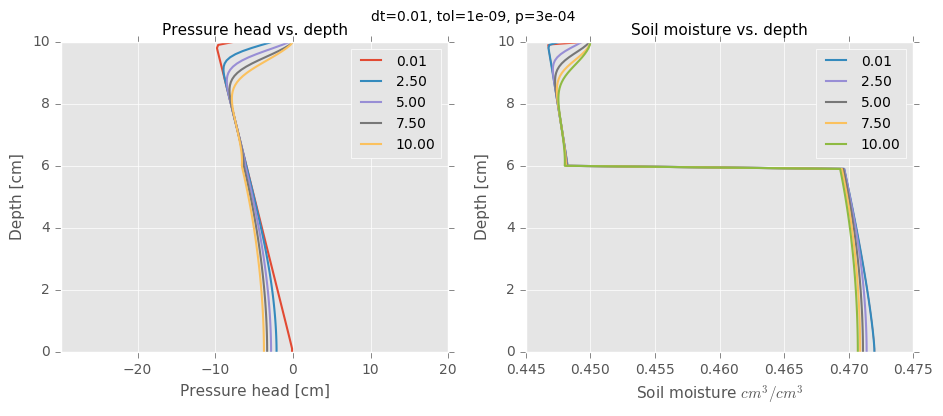

In [90]:
# 1. profile
fig = plt.figure(1, figsize = (11,4)); 
ax = plt.subplot(121)
plt.xlabel('Pressure head [cm]',fontsize=  11)
plt.plot(H[:, 1],z, label = '{0:.2f}'.format(t[1]), lw = 1.5)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.xlim( np.min(H)-20,  np.max(H)+20)
plt.title('Pressure head vs. depth', fontsize=  11)

ax = plt.subplot(122)
plt.plot(thetainit,z)
plt.xlabel('Soil moisture $cm^3/cm^3$',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.plot(THETA[:, 1],z, label = '{0:.2f}'.format(t[1]), lw = 1.5)
plt.title('Soil moisture vs. depth',fontsize=  11)

for i in  range(len(t)/4, len(t), len(t)/4):
    ax = plt.subplot(121)
    plt.plot(H[:, i],z, label = '{0:.2f}'.format(t[i]), lw = 1.5)
    plt.legend(loc = 'best', fontsize = 10)
    ax = plt.subplot(122)
    plt.plot(THETA[:, i],z, label = '{0:.2f}'.format(t[i]), lw = 1.5)
    plt.legend(loc = 'best', fontsize = 10)
    
plt.suptitle(fmtstr)
fig.savefig('case_{1}/profile {0}.pdf'.format(fmtstr, case))

In [93]:
(H[-1] - H[-2])/dz 

array([ 99.        ,  20.32728997,  20.25805979, ...,   3.26840247,
         3.26533452,   3.2622734 ])

In [74]:
ktop*3600

array([ 0.11810891,  0.04976855,  0.04993115, ...,  0.19      ,
        0.19      ,  0.19      ])

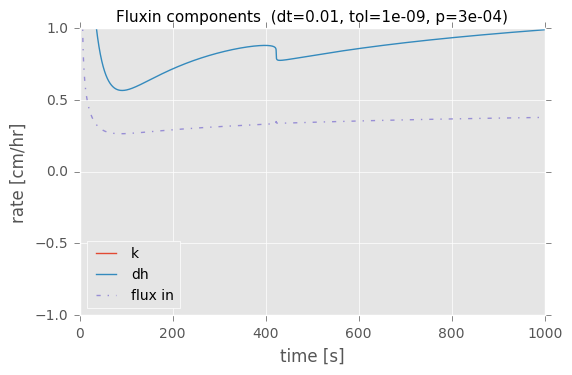

In [67]:
# 2. flux rates
fig = plt.figure(1, figsize = (6,3.7))
plt.title('Fluxin components  ({0})'.format(fmtstr), fontsize = 11)
plt.plot(t[1:], (K[-1, 1:]+ K[-2, 1:])/2./dt*3600, label = 'k')
plt.plot(t[1:], (H[-1, 1:]- H[-2, 1:])/dz, label = 'dh')
plt.plot(t[1:], fluxin[1:]/dt*3600, '-.', ms = 4, label = 'flux in')
plt.legend(loc = 'best', fontsize = 10)
plt.ylim(-1,1)
plt.xlabel('time [s]') 
plt.ylabel('rate [cm/hr]')


In [55]:
 fluxin[1:]/dt*3600

array([ 1.0614282 ,  1.06143939,  1.06145123, ...,  0.37794775,
        0.37794822,  0.37794869])

In [60]:
kt*3600

0.19

In [61]:
ksat[-1]*3600

0.19

In [62]:
fluxin[1:]/dt*3600

array([ 1.0614282 ,  1.06143939,  1.06145123, ...,  0.37794775,
        0.37794822,  0.37794869])

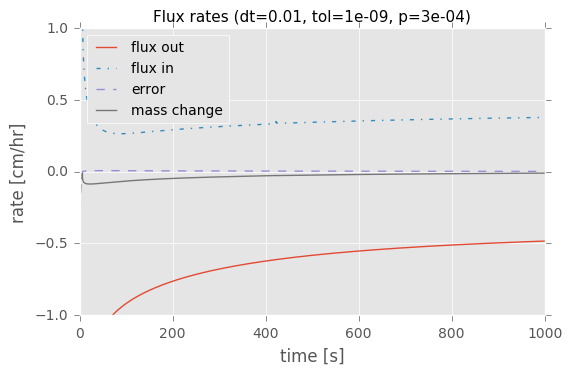

In [49]:
# 2. flux rates
fig = plt.figure(1, figsize = (6,3.7))

plt.title('Flux rates ({0})'.format(fmtstr), fontsize = 11)
plt.plot(t[1:], fluxout[1:]/dt*3600, label = 'flux out')
plt.plot(t[1:], fluxin[1:]/dt*3600, '-.', ms = 4, label = 'flux in')
plt.plot(t[1:], error[1:]/dt*3600, '--',  label = 'error')
plt.plot(t[2:], newmass[1:]*dz/dt*3600, label = 'mass change')
plt.legend(loc = 'best', fontsize = 10)
plt.ylim(-1,1)
plt.xlabel('time [s]') 
plt.ylabel('rate [cm/hr]')
fig.savefig('case_{1}/flux rates {0}.pdf'.format(fmtstr, case) )

In [50]:
fluxin =    ktop*((H[-1] - H[-2])/dz + 1.)*dt   # top flux (cm)
kbot = (K[60] + K[59])/2.
fluxout = - kbot*((H[60] - H[59])/dz + 1.)*dt # bottom flux (cm)
newmass =  (THETA[60:, 1:] - THETA[60:, :-1]).sum(0)*dz   #  change in mass 


In [51]:
ktop = (K[-1] + K[-2])/2.
fluxin =    ktop*((H[-1] - H[-2])/dz + 1.)*dt   # top flux (cm)
kbot = (K[0] + K[1])/2.
fluxout = - kbot*((H[1] - H[0])/dz + 1.)*dt # bottom flux (cm)
newmass =  (THETA[:, 1:] - THETA[:, :-1]).sum(0)*dz   #  change in mass 


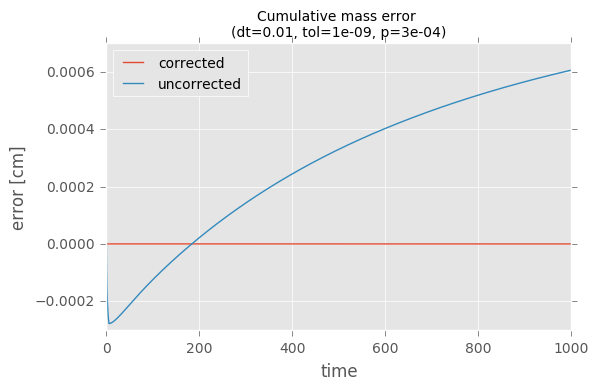

In [52]:
# 3.  cumulative error
fig = plt.figure(1, figsize = (6,3.7))
plt.title('Cumulative mass error \n({0})'.format(fmtstr), fontsize = 10)
plt.plot(t[2:], np.cumsum(fluxin[2:] - newmass[1:] + fluxout[2:] - error[2:] ), label =  'corrected')

plt.plot(t[2:], np.cumsum(fluxin[2:] - newmass[1:] + fluxout[2:]  ), label =  'uncorrected')

# plt.plot(t[2:], np.cumsum( fluxout[2:]  ), label = 'fluxout')
# plt.plot(t[2:], np.cumsum(fluxin[2:]  ), label = 'in')

# plt.plot(t[2:], np.cumsum( -  newmass[1:]  ), label = 'mass')

plt.xlabel('time')
plt.ylabel('error [cm]')
plt.legend(loc = 'best', fontsize = 10)
fig.savefig('case_{1}/error {0}.pdf'.format(fmtstr, case))

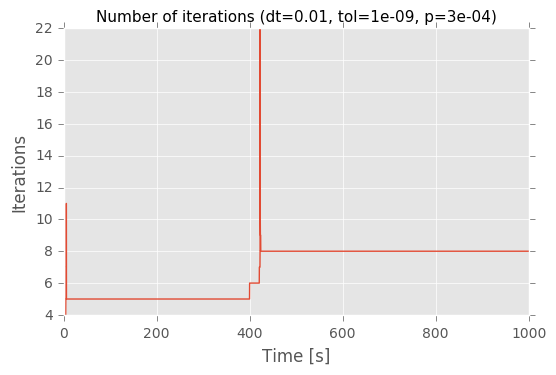

In [53]:
# 4. Number of iterations
fig = plt.figure(1, figsize = (6,3.7))
plt.plot(t[1:],iterations[1:],'-')
plt.xlabel('Time [s]')
plt.title('Number of iterations ({0})'.format(fmtstr), fontsize = 11)
plt.ylabel('Iterations')
fig.savefig('case_{1}/iterations {0}.pdf'.format(fmtstr, case))

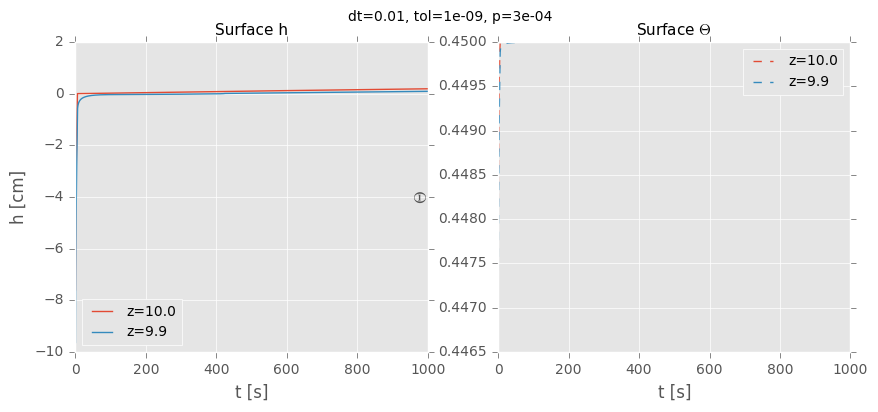

In [54]:
fig  = plt.figure(1, figsize = (10,4)); 
ax = plt.subplot(121)
plt.title('Surface h',  fontsize = 11)
plt.plot(t[1:], H[-1, 1:], label = 'z={}'.format(z[-1]))
plt.plot(t[1:], H[-2, 1:], label = 'z={}'.format(z[-2]))
plt.xlabel('t [s]'); plt.ylabel('h [cm]')
plt.legend(loc = 'best', fontsize = 10)
ax = plt.subplot(122)
plt.title('Surface $\Theta$',  fontsize = 11)
plt.plot(t[1:], THETA[-1, 1:], '--', label = 'z={}'.format(z[-1]))
plt.plot(t[1:], THETA[-2, 1:], '--', label = 'z={}'.format(z[-2]))
plt.legend(loc = 'best', fontsize = 10)
plt.xlabel('t [s]'); plt.ylabel('$\Theta$')
plt.suptitle('{}'.format(fmtstr))
fig.savefig('case_{1}/surface_{0}.pdf'.format(fmtstr, case))